In [1]:
from googleapiclient.discovery import build 
import pandas as pd 
import seaborn as sns 


In [66]:
api_key = 'Your api key'
sidemen_channels= ['UCGmnsW623G1r-Chmo5RB4Yw', #jj
                  
                   ]


youtube = build('youtube', 'v3', developerKey=api_key)

In [68]:
def get_channel_stat(youtube, sidemen_channels):
    data = []
    for channel_id in sidemen_channels:
        request = youtube.channels().list(
            part='snippet,contentDetails,statistics',
            id=channel_id
        )
        response = request.execute()
        channel_name = response['items'][0]['snippet']['title']
        subscriber_count = response['items'][0]['statistics']['subscriberCount']
        views = response['items'][0]['statistics']['viewCount']
        total_videos = response['items'][0]['statistics']['videoCount']
        play= response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
       
        data.append({
            'Channel Name': channel_name,
            'Subscriber Count': subscriber_count,
            'Views': views,
            'Total Videos': total_videos,
            'Play' : play
        })
    return pd.DataFrame(data)

In [91]:
channel_data = get_channel_stat( youtube , sidemen_channels)
channel_data


,Channel Name,Subscriber Count,Views,Total Videos,Play
0,JJ Olatunji,16200000,3981871712,1260,UUGmnsW623G1r-Chmo5RB4Yw


In [70]:
playlist_id = channel_data.loc[channel_data['Channel Name'] == 'JJ Olatunji' , 'Play' ].iloc[0]
playlist_id

'UUGmnsW623G1r-Chmo5RB4Yw'

In [71]:
def get_video_ids(youtube, playlist_id):
    
    request = youtube.playlistItems().list(
        part='contentDetails',
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    video_ids = []
    for i in range (len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])

    next_page = response.get('nextPageToken')
    more_pages = True

    while more_pages:
        if next_page is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId=playlist_id,
                    maxResults = 50,
                     pageToken = next_page ) 
            response = request.execute()

            for i in range (len(response['items'])):
              video_ids.append(response['items'][i]['contentDetails']['videoId'])

            next_page = response.get('nextPageToken')
        


    return video_ids

In [ ]:
video_ids = get_video_ids ( youtube , playlist_id)
video_ids

In [118]:
def get_video_details(youtube, video_ids):
    allstats = []
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part='snippet,statistics',
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()
        for video in response['items']:
            video_stats = dict(
                Title=video['snippet']['title'],
                Publised_date=video['snippet']['publishedAt'],
                Views=video['statistics']['viewCount']
            )
            allstats.append(video_stats)
    return pd.DataFrame(allstats)

    

In [ ]:
video_details = get_video_details ( youtube, video_ids)
final_data = pd.DataFrame(video_details)
final_data


In [125]:
final_data['Publised_date'] = pd.to_datetime(final_data['Publised_date']).dt.date
final_data['Views'] = pd.to_numeric(final_data['Views'])


In [130]:
top_10 = final_data.sort_values(by='Views' , ascending = False).head(10)
top_10

,Title,Publised_date,Views
746,KSI Plays | A RACIST COMPUTER PROGRAM,2014-08-26,26488395
418,TRY NOT TO PERISH CHALLENGE,2019-02-26,22539587
202,TRY NOT TO LAUGH (African Edition 2),2020-12-08,22504056
240,It‘s So Hard Not To Laugh At This,2020-10-01,21673292
417,TRY NOT TO LAUGH (ULTIMATE EDITION),2019-02-27,21169682
186,Try Not To Laugh (Inappropriate Edition),2021-02-10,19066271
347,REACTING TO EVERY DISSTRACK AT ME,2020-04-19,18794556
439,GUESS HER AGE?,2019-02-04,18736125
472,Watching Weird Videos,2019-01-02,18556313
337,TRY NOT TO LAUGH DANK MEMES,2020-04-30,18392629


In [132]:
final_data.to_csv('jj_youtube_career.csv', index=False)


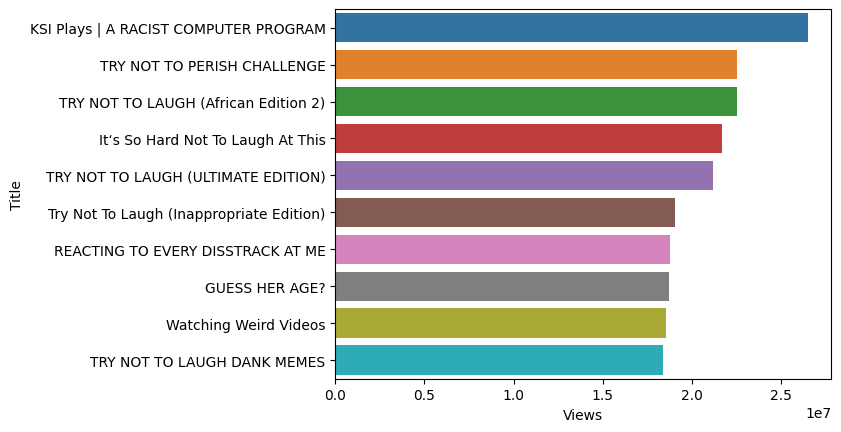

In [131]:
plot = sns.barplot( x = 'Views' , y='Title' , data=top_10)